In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse

from keras import utils
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Layer, Input, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Reshape, Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Concatenate, Bidirectional, GRU

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Классификация текстов по возрастным группам авторов дневниковых записей**

## **Подготовка данных**

In [33]:
data = pd.read_csv('/content/drive/MyDrive/диссертация/data/data_preprocessing_final.csv')

<ipython-input-33-68012c472933>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/диссертация/data/data_preprocessing_final.csv')


In [34]:
del data['Unnamed: 0']
data.head()

,id,diary,text,date,sex,birth,age,text_preprocessing
0,693,3,Сейчас бьет на башенных часах 12. Полночь. Жен...,1932-09-28,1.0,1890-05-25,42.0,бить башенный часы полночь жена спать ребенок ...
1,694,3,"Читал Шаляпина — воспоминания. Оказывается, ис...",1932-10-06,1.0,1890-05-25,42.0,читать шаляпин воспоминание оказываться истори...
2,695,3,При социализме заводы суть храмы и центры чело...,1932-10-20,1.0,1890-05-25,42.0,социализм завод храм центр человеческий житие ...
3,696,3,Завтра с утра — в Москву. Что-то меня там ждет...,1932-10-30,1.0,1890-05-25,42.0,завтра утро москва ждать каково настроение шир...
4,697,3,"В Берлине, в полпредстве, оказался Горький (пр...",1932-11-01,1.0,1890-05-25,42.0,берлин полпредство оказываться горький проезд ...


In [35]:
data = data.dropna()
data['age'] = data['age'].astype(int)

<ipython-input-35-af701e9819cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age'] = data['age'].astype(int)


# **Разведочный анализ данных**

In [36]:
data['age'].describe()

count    437142.000000
mean         42.747004
std          17.639055
min           0.000000
25%          28.000000
50%          41.000000
75%          57.000000
max          96.000000
Name: age, dtype: float64

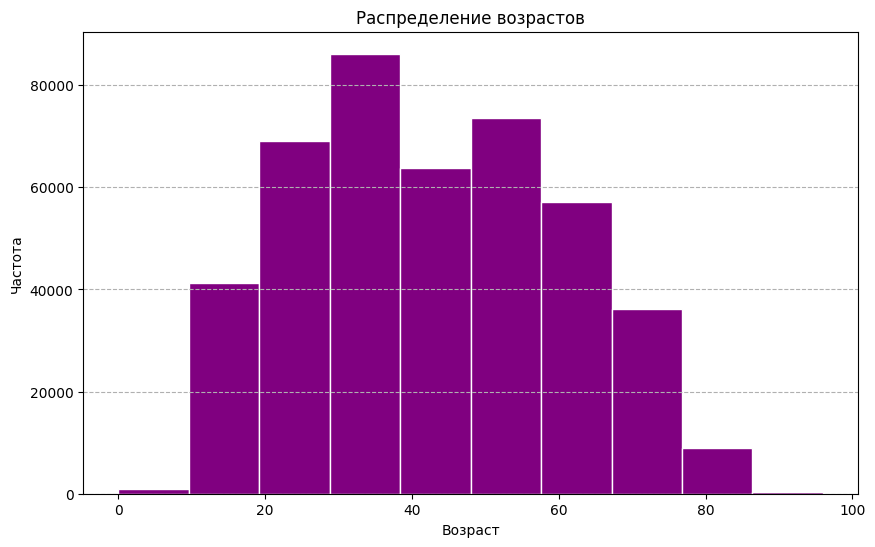

In [37]:
# Гистограмма
plt.figure(figsize=(10, 6))
plt.hist(data['age'], bins=10, color='purple', edgecolor='white')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возрастов')
plt.grid(axis='y', linestyle='--')
plt.show()

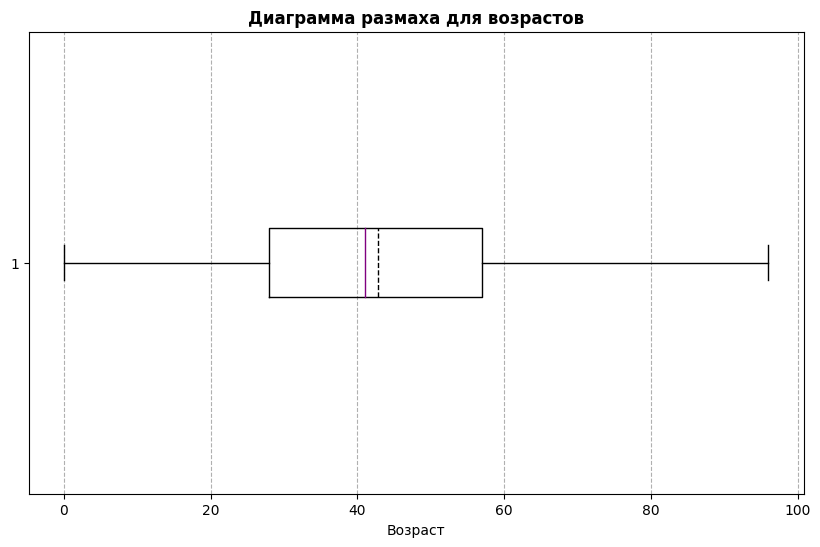

In [38]:
# Ящик с усами
plt.figure(figsize=(10, 6))
box = plt.boxplot(data['age'], vert=False, showmeans=True, meanline=True)
avr_colors = ['black']
median_color = 'purple'
box['means'][0].set(color=avr_colors[0])
box['medians'][0].set(color=median_color)
plt.title('Диаграмма размаха для возрастов', fontweight='bold')
plt.xlabel('Возраст')
plt.grid(axis='x', linestyle='--')
plt.show()

In [39]:
data = data[data['age'] != 0]
data = data[data['age'] > 17]

In [40]:
unique_ages = data['age'].nunique()
print(f'Количество уникальных значений в столбце «age»: {unique_ages}')

Количество уникальных значений в столбце «age»: 78


In [41]:
mean_age = data['age'].mean()
median_age = data['age'].median()
print(f"Средний возраст: {round(mean_age)}")
print(f"Медианный возраст: {round(median_age)}")

Средний возраст: 45
Медианный возраст: 43


## **Кластеризация данных**
Для понимания количества возрастных групп, на которые можно поделить данные.

In [42]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(data['text_preprocessing'])

In [43]:
lsa = TruncatedSVD(n_components=50)
X_lsa = lsa.fit_transform(X)

In [44]:
# Кластеризация методом K-means
k = 3  # Предполагаемое количество возрастных групп
kmeans = KMeans(n_clusters=k, random_state=42)
data['age_group'] = kmeans.fit_predict(X_lsa)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


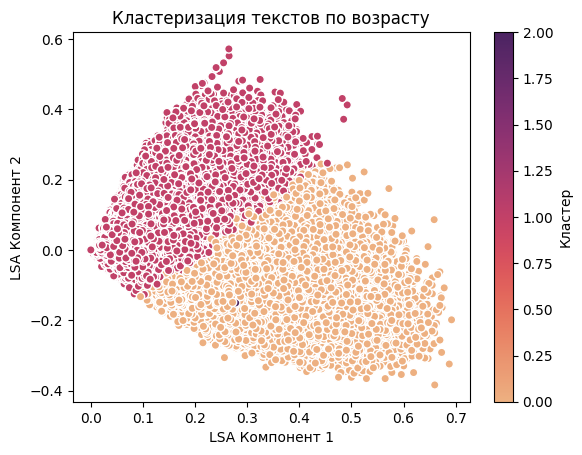

In [45]:
# Отображение результатов кластеризации
plt.scatter(X_lsa[:, 0], X_lsa[:, 1], c=data['age_group'], edgecolor='white', cmap='flare')
plt.xlabel('LSA Компонент 1')
plt.ylabel('LSA Компонент 2')
plt.title('Кластеризация текстов по возрасту')
plt.colorbar(label='Кластер')
plt.show()

In [46]:
age_group_mapping = {}

for index, row in data.iterrows():
    age = row['age']
    age_group = row['age_group']

    # Проверка, есть ли возрастная группа в словаре
    if age_group in age_group_mapping:
        age_group_mapping[age_group].append(age)
    else:
        age_group_mapping[age_group] = [age]

# Вывод топ-10 наиболее часто встречающихся возрастов для каждой возрастной группы
for age_group, ages in age_group_mapping.items():
    age_counts = pd.Series(ages).value_counts()  # Подсчет количества каждого возраста
    top_ages = age_counts.head(10)  # Выбор топ-10 возрастов
    print(f"Топ-10 возрастов в возрастной группе {age_group}:")
    print(top_ages)

Топ-10 возрастов в возрастной группе 0:
54    3088
49    3063
20    2995
55    2964
50    2943
33    2941
57    2905
56    2729
19    2727
44    2688
Name: count, dtype: int64
Топ-10 возрастов в возрастной группе 1:
33    7718
34    6713
32    6621
35    6552
37    6387
36    6125
28    5762
25    5655
30    5575
26    5500
Name: count, dtype: int64
Топ-10 возрастов в возрастной группе 2:
31    441
32    391
49    276
52    267
48    257
50    256
51    234
53    177
57    143
42    137
Name: count, dtype: int64


In [47]:
age_groups = {'18-35': [], '36-55': [], '56+': []}

# Группировка текстов по возрастным группам
for index, row in data.iterrows():
    text = row['text_preprocessing']
    age = row['age']

    if age >= 18 and age <= 35:
        age_groups['18-35'].append(text)
    elif age >= 36 and age <= 55:
        age_groups['36-55'].append(text)
    elif age >= 56:
        age_groups['56+'].append(text)

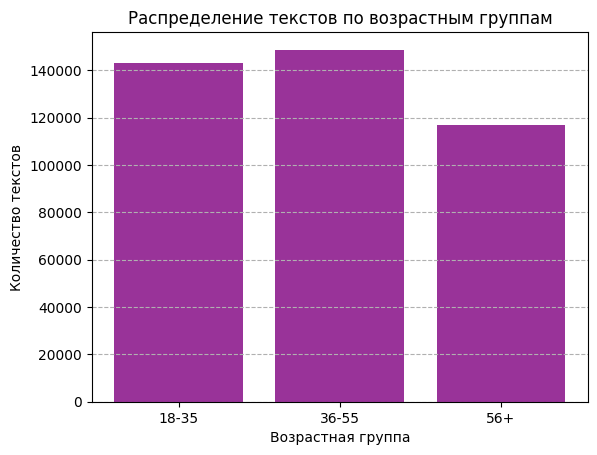

In [48]:
# Создаем список возрастных групп и количество текстов в каждой группе
age_groups_count = [(group, len(texts)) for group, texts in age_groups.items()]

# Разделяем возрастные группы и количество текстов на отдельные списки
groups, counts = zip(*age_groups_count)

# Создаем график
plt.bar(groups, counts, color='purple', alpha=0.8)
plt.xlabel('Возрастная группа')
plt.ylabel('Количество текстов')
plt.title('Распределение текстов по возрастным группам')
plt.grid(axis='y', linestyle='--')
plt.show()

In [49]:
age_groups_count

[('18-35', 143177), ('36-55', 148669), ('56+', 116680)]

In [50]:
# Создание словаря для соответствия возрастных групп
age_groups = {
    (18, 35): '18-35',
    (36, 55): '36-55',
    (56, 100): '56+',
}

# Функция для определения возрастной группы
def get_age_group(age):
    for age_range, group in age_groups.items():
        if age >= age_range[0] and age <= age_range[1]:
            return group

# Применение функции к столбцу "age" и создание нового столбца "age_group"
data['age_group'] = data['age'].apply(get_age_group)

In [51]:
data.head()

,id,diary,text,date,sex,birth,age,text_preprocessing,age_group
0,693,3,Сейчас бьет на башенных часах 12. Полночь. Жен...,1932-09-28,1.0,1890-05-25,42,бить башенный часы полночь жена спать ребенок ...,36-55
1,694,3,"Читал Шаляпина — воспоминания. Оказывается, ис...",1932-10-06,1.0,1890-05-25,42,читать шаляпин воспоминание оказываться истори...,36-55
2,695,3,При социализме заводы суть храмы и центры чело...,1932-10-20,1.0,1890-05-25,42,социализм завод храм центр человеческий житие ...,36-55
3,696,3,Завтра с утра — в Москву. Что-то меня там ждет...,1932-10-30,1.0,1890-05-25,42,завтра утро москва ждать каково настроение шир...,36-55
4,697,3,"В Берлине, в полпредстве, оказался Горький (пр...",1932-11-01,1.0,1890-05-25,42,берлин полпредство оказываться горький проезд ...,36-55


In [52]:
data['age_group'].describe()

count     408526
unique         3
top        36-55
freq      148669
Name: age_group, dtype: object

In [53]:
data = data.dropna()

# **Эксперименты по определению возрастной группы автора с помощью классических алгоритмов МО**

## **№1: LogitRegression**

In [24]:
# Разделение на признаки и целевую переменную
X = data['text_preprocessing']
y = data['age_group']

# Разделение на обучающую и тестовую выборки
#y = np.array([val if val is not None else '' for val in y])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Заменяем все значения NaN пустой строкой
X_train.fillna('', inplace=True)
X_test.fillna('', inplace=True)

# Векторизация текста
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [25]:
# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Предсказания на тестовых данных
y_pred = model.predict(X_test_vec)

# Оценка модели
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       18-35       0.74      0.76      0.75     28636
       36-55       0.67      0.69      0.68     29734
         56+       0.75      0.69      0.72     23336

    accuracy                           0.72     81706
   macro avg       0.72      0.71      0.72     81706
weighted avg       0.72      0.72      0.72     81706



In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

Точность модели: 0.7154287018487054


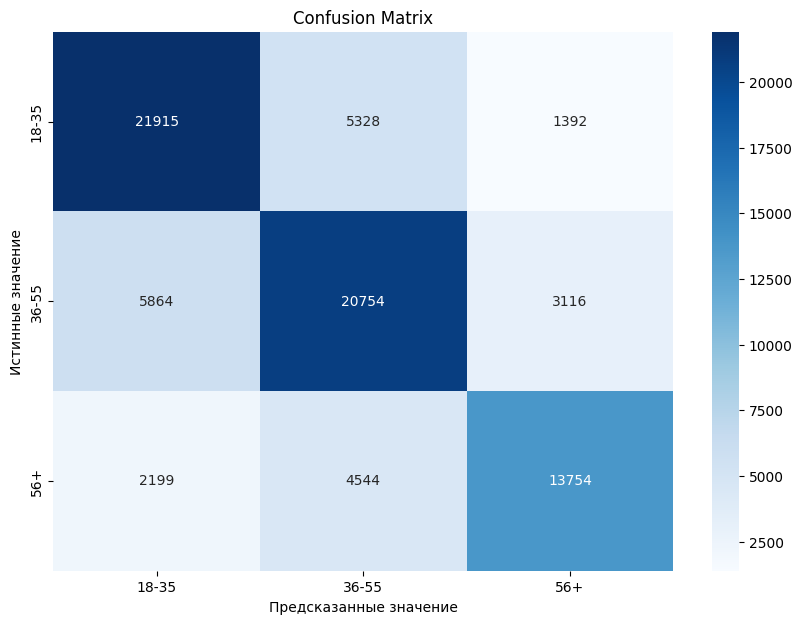

In [ ]:
# Вычисление матрицы ошибок
conf_mat = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Предсказанные значение')
plt.ylabel('Истинные значение')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Получение важных слов
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_.flatten()[:434362]

# Создание DataFrame с результатами
importance_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
})

# Сортировка по важности
importance_df = importance_df.sort_values(by='coefficient', ascending=False)

# Вывод самых важных слов
print("Слова, которые больше всего повлияли на принятие решений модели:")
print(importance_df.head(30))

Слова, которые больше всего повлияли на принятие решений модели:
                word  coefficient
137222          ирка    10.868225
365813      сьогодні     8.064075
34                аа     6.758024
20254          барин     6.542416
214362        нардом     6.132878
244671        оновна     4.942780
412560           чес     4.788011
71442     георгиевна     4.708554
359674     столярный     4.544739
54690        военком     4.415557
131667        игорек     4.384136
317155            рб     4.225313
107249         еркин     4.205455
434233       яшенька     4.119378
143140  камераливать     4.107479
35594            бсэ     4.076467
143720      кандагар     4.027141
266579       пианино     4.016911
127062        зинуля     3.976989
31464        болтать     3.924233
254538        павлик     3.899331
229498        никаха     3.863381
373792       тищенко     3.847384
329451      савицкий     3.842895
414096      читальня     3.817630
6486           аликс     3.817357
378546    трифоно

## **№2: Multinominal Naive Bayes**

In [54]:
# Предобработка текста (предполагается, что текст уже предобработан и находится в столбце 'text_preprocessing')
X = data['text_preprocessing']
y = data['age_group']

X.fillna('', inplace=True)

# Преобразование текста в матрицу признаков
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

# Разделение данных на обучающий и тестовый наборы
#y = np.array([val if val is not None else '' for val in y])
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)

In [56]:
# Инициализация и обучение модели наивного Байеса
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = nb_model.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')
print(classification_report(y_test, y_pred))

Точность модели: 0.6550314542383668
              precision    recall  f1-score   support

       18-35       0.64      0.78      0.70     28636
       36-55       0.67      0.55      0.60     29734
         56+       0.67      0.64      0.65     23336

    accuracy                           0.66     81706
   macro avg       0.66      0.66      0.65     81706
weighted avg       0.66      0.66      0.65     81706



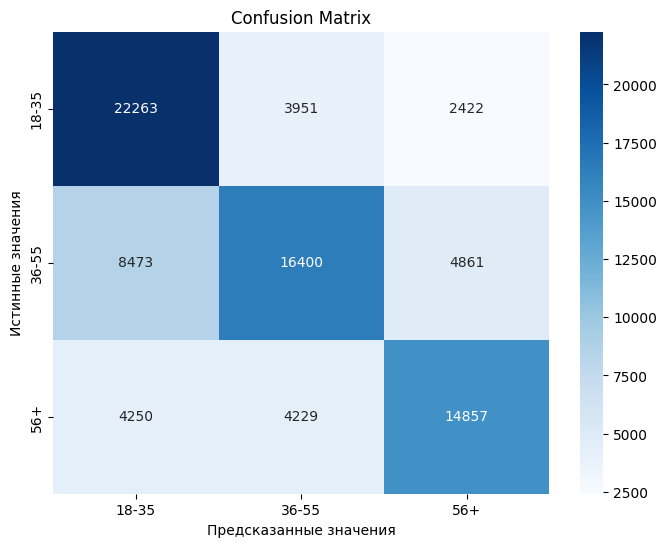

In [57]:
# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Отображение матрицы ошибок в виде тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Confusion Matrix')
plt.show()

# **Эксперименты по определению возрастной группы автора с помощью глубинного обучения**

## **Подготовка текстов**

In [ ]:
data['text_preprocessing'] = data['text_preprocessing'].fillna('')

In [ ]:
# Токенизация текста
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text_preprocessing'])
word_index = tokenizer.word_index

In [ ]:
# Конвертация текстов в последовательности
sequences = tokenizer.texts_to_sequences(data['text_preprocessing'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [ ]:
# Подготовка целевой переменной
labels = pd.get_dummies(data['age_group']).values

In [ ]:
# Разбиение на тренировочный и тестовый наборы данных
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels)

## **Модели**

### **№1: CNN1D**

In [ ]:
model_1 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_1 = model_1.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/35
4930/4930 [==============================] - 425s 86ms/step - loss: 0.9221 - accuracy: 0.5424 - val_loss: 0.8208 - val_accuracy: 0.6096
Epoch 2/35
4930/4930 [==============================] - 424s 86ms/step - loss: 0.8151 - accuracy: 0.6188 - val_loss: 0.7886 - val_accuracy: 0.6302
Epoch 3/35
4930/4930 [==============================] - 445s 90ms/step - loss: 0.7651 - accuracy: 0.6468 - val_loss: 0.7730 - val_accuracy: 0.6375
Epoch 4/35
4930/4930 [==============================] - 430s 87ms/step - loss: 0.7173 - accuracy: 0.6743 - val_loss: 0.7664 - val_accuracy: 0.6421
Epoch 5/35
4930/4930 [==============================] - 430s 87ms/step - loss: 0.6707 - accuracy: 0.6977 - val_loss: 0.7796 - val_accuracy: 0.6399
Epoch 6/35
4930/4930 [==============================] - 442s 90ms/step - loss: 0.6219 - accuracy: 0.7212 - val_loss: 0.8171 - val_accuracy: 0.6383
Epoch 7/35
4930/4930 [==============================] - 425s 86ms/step - loss: 0.5746 - accuracy: 0.7454 - val_loss: 0

2465/2465 [==============================] - 36s 14ms/step - loss: 0.8565 - accuracy: 0.6352
Функционал ошибки: 0.8564665913581848 
Точность модели: 0.6352167129516602


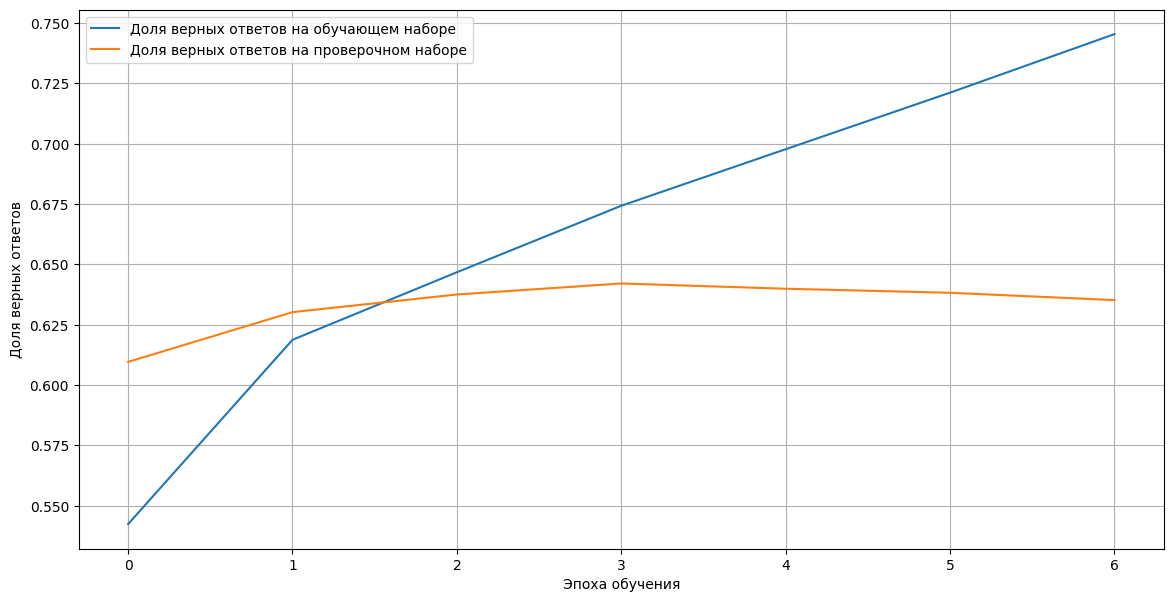

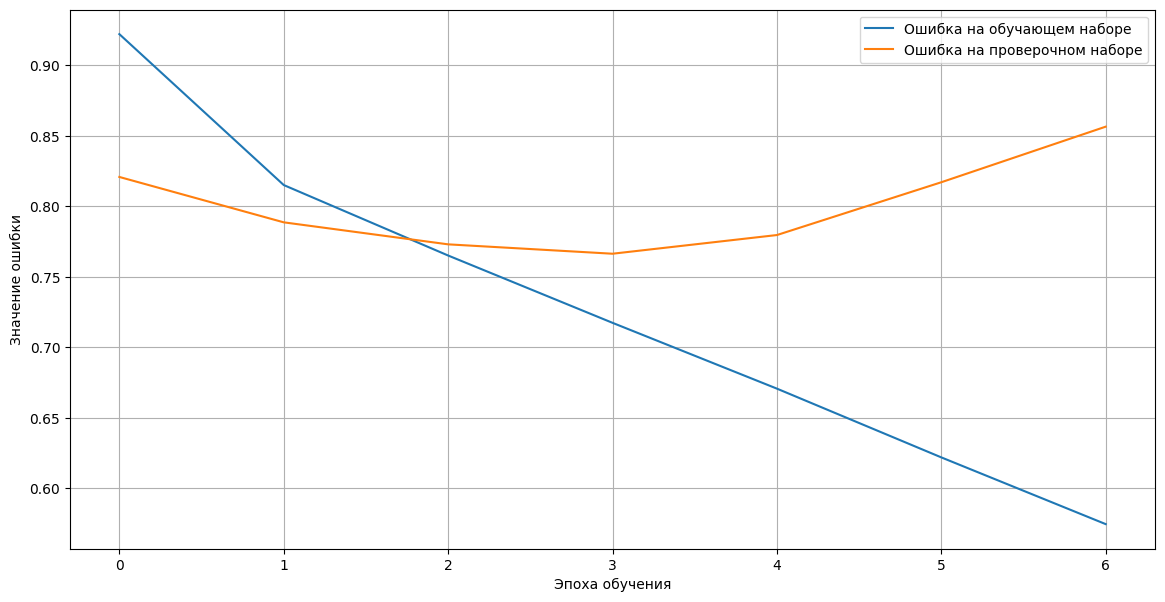

In [ ]:
val_loss, val_accuracy = model_1.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

plt.figure(figsize=(14,7))
plt.plot(history_1.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_1.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history_1.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_1.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Сохранение модели
model_1.save('model_age_CNN1D.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **№2: LSTM + CNN1D**

In [ ]:
model_2 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),  # Увеличим размерность Embedding
    SpatialDropout1D(0.4),  # Увеличим коэффициент Dropout

    Conv1D(256, 3, activation='relu'),  # Увеличим количество фильтров и уменьшим размер ядра
    GlobalMaxPooling1D(),
    Dropout(0.4),

    Reshape((1, -1)),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.4),

    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(3, activation='softmax')
])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_2 = model_2.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/35
5107/5107 [==============================] - 107s 19ms/step - loss: 0.9113 - accuracy: 0.5473 - val_loss: 0.8333 - val_accuracy: 0.6054
Epoch 2/35
5107/5107 [==============================] - 53s 10ms/step - loss: 0.8381 - accuracy: 0.6032 - val_loss: 0.8119 - val_accuracy: 0.6165
Epoch 3/35
5107/5107 [==============================] - 50s 10ms/step - loss: 0.8130 - accuracy: 0.6186 - val_loss: 0.7993 - val_accuracy: 0.6207
Epoch 4/35
5107/5107 [==============================] - 53s 10ms/step - loss: 0.7970 - accuracy: 0.6278 - val_loss: 0.7927 - val_accuracy: 0.6285
Epoch 5/35
5107/5107 [==============================] - 50s 10ms/step - loss: 0.7857 - accuracy: 0.6355 - val_loss: 0.7954 - val_accuracy: 0.6280
Epoch 6/35
5107/5107 [==============================] - 50s 10ms/step - loss: 0.7757 - accuracy: 0.6417 - val_loss: 0.7811 - val_accuracy: 0.6340
Epoch 7/35
5107/5107 [==============================] - 51s 10ms/step - loss: 0.7666 - accuracy: 0.6469 - val_loss: 0.7799 

2554/2554 [==============================] - 10s 4ms/step - loss: 0.7765 - accuracy: 0.6395
Функционал ошибки: 0.7765047550201416 
Точность модели: 0.6395368576049805


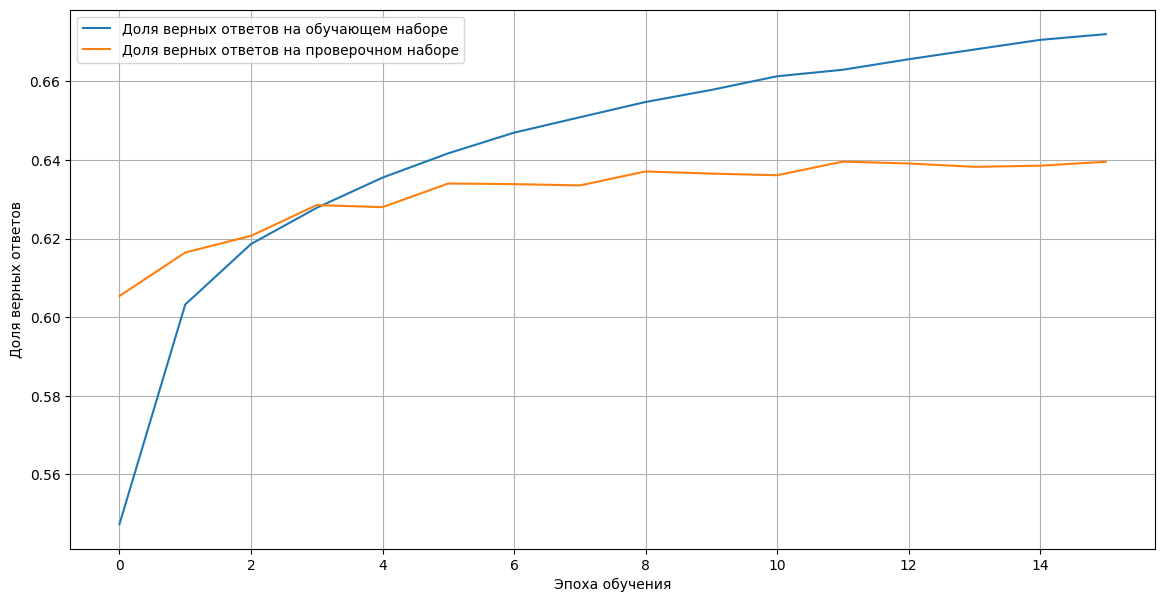

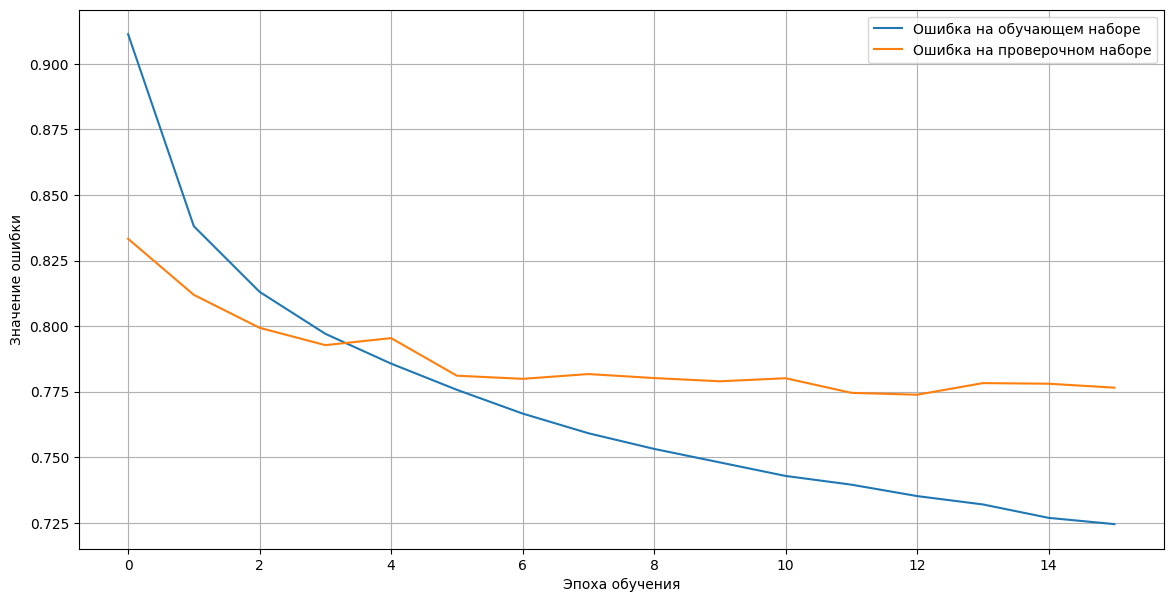

In [ ]:
val_loss, val_accuracy = model_2.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

plt.figure(figsize=(14,7))
plt.plot(history_2.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_2.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history_2.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_2.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model_2.save('model_age_LSTM_CNN1D.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **№3: BiLSTM + LSTM**

In [ ]:
model_3 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.4),
    BatchNormalization(),

    Bidirectional(LSTM(64, return_sequences=True)),  # Добавлен возврат последовательностей для следующего LSTM слоя
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),

    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model_3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_3 = model_3.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/35
5094/5107 [============================>.] - ETA: 5s - loss: 0.9710 - accuracy: 0.5076

2554/2554 [==============================] - 33s 13ms/step - loss: 0.7396 - accuracy: 0.6690
Функционал ошибки: 0.7396306991577148 
Точность модели: 0.6689961552619934


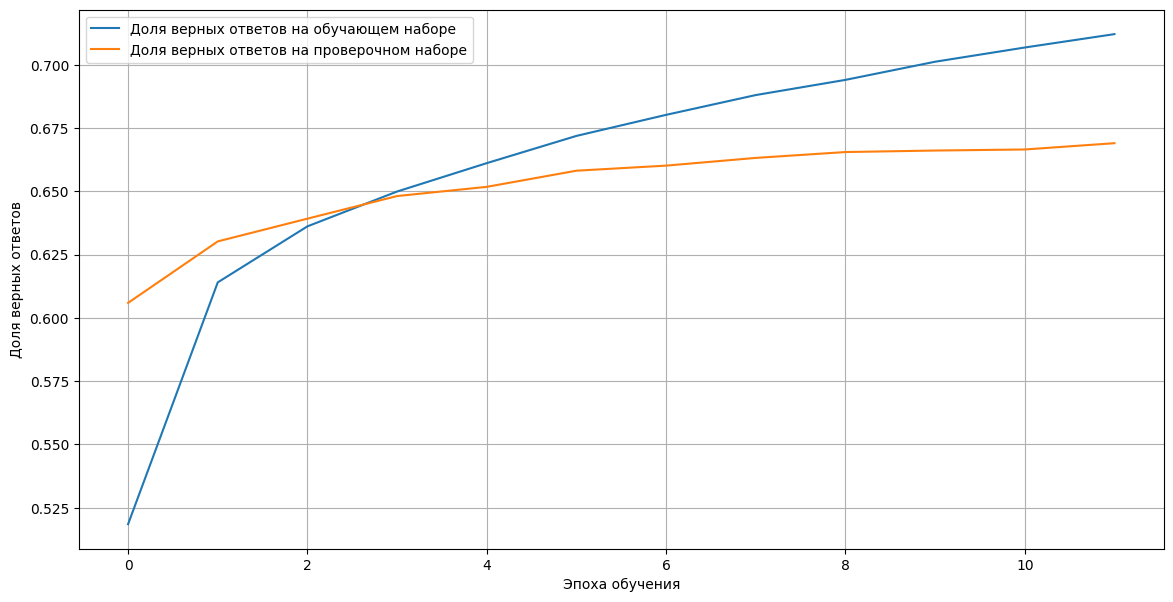

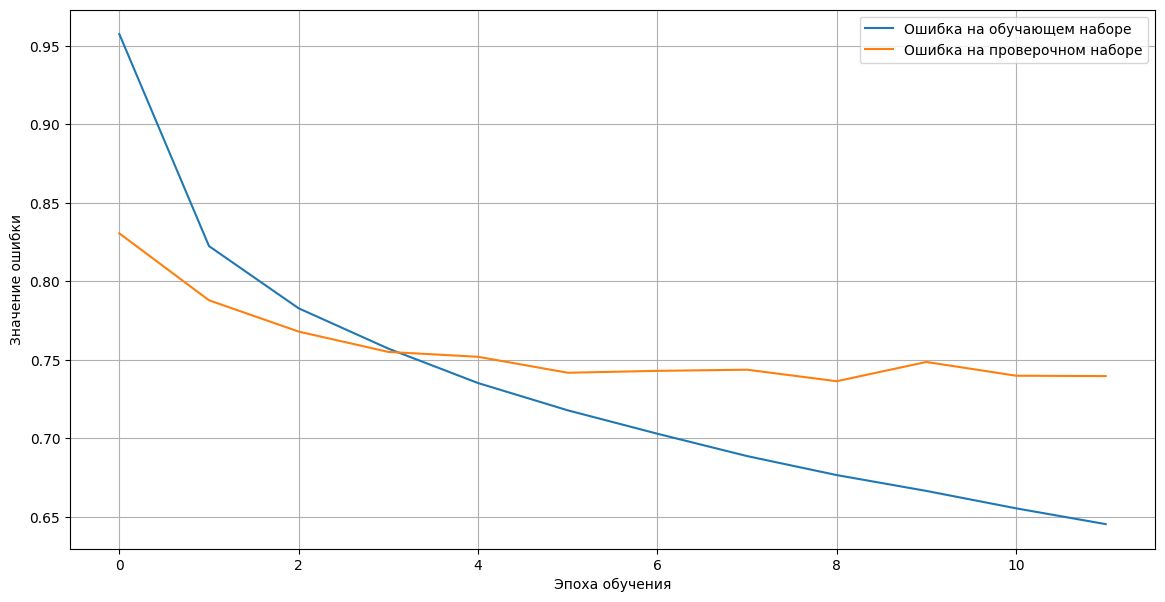

In [ ]:
val_loss, val_accuracy = model_3.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

plt.figure(figsize=(14,7))
plt.plot(history_3.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_3.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history_3.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_3.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model_3.save('model_age_LSTM_BiLSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
